**Overview** <br>
Working with hundreds of anonymized features to predict if a customer is satisfied or dissatisfied with their banking experience.<br>

The "TARGET" column is the variable to predict. It equals one for unsatisfied customers and 0 for satisfied customers.

The goal is to predict the probability that each customer in the test set is an unsatisfied customer.

**Data File descriptions**<br>
train.csv - the training set including the target<br>
test.csv - the test set without the target

****Import Libraries****

In [52]:
# Data processing
import numpy as np
import pandas as pd
import random
import itertools
from scipy import stats
from scipy.sparse import hstack

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Modeling
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import roc_curve, roc_auc_score, log_loss

# System / Settings
from tqdm import tqdm
import warnings
import time

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set(palette='muted', style='whitegrid')
np.random.seed(13154)

****Load Data****

In [2]:
train = pd.read_csv('/kaggle/input/santander-customer-satisfaction/train.csv')
test = pd.read_csv('/kaggle/input/santander-customer-satisfaction/test.csv')
print("Number of training samples: %i, number of features: %i" % (train.shape[0], train.shape[1]))
print("Number of test samples: %i, number of features: %i" % (test.shape[0], test.shape[1]))

Number of training samples: 76020, number of features: 371
Number of test samples: 75818, number of features: 370


In [3]:
train.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117310.979016,0


In [4]:
test.head()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38
0,2,2,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40532.10
1,5,2,35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45486.72
2,6,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46993.95
3,7,2,24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,187898.61
4,9,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,73649.73


**EDA & Feature Engineering**

In [5]:
# Filter zero-variance features
i = 0
for col in train.columns:
    if train[col].var() == 0:
        i += 1
        del train[col]
        del test[col]
print("%i features with zero variance have been removed" % (i))

34 features with zero variance have been removed


In [6]:
# Filter sparse features
i = 0
for col in train.columns:
    if np.percentile(train[col], 99) == 0:
        i += 1
        del train[col]
        del test[col]
        
print("%i sparse features have been removed" % (i))

188 sparse features have been removed


In [7]:
#Get pairwise combinations of all columns
combinations = list(itertools.combinations(train.columns, 2))
print(combinations[:20])
len(combinations)

[('ID', 'var3'), ('ID', 'var15'), ('ID', 'imp_ent_var16_ult1'), ('ID', 'imp_op_var39_comer_ult1'), ('ID', 'imp_op_var39_comer_ult3'), ('ID', 'imp_op_var41_comer_ult1'), ('ID', 'imp_op_var41_comer_ult3'), ('ID', 'imp_op_var41_efect_ult1'), ('ID', 'imp_op_var41_efect_ult3'), ('ID', 'imp_op_var41_ult1'), ('ID', 'imp_op_var39_efect_ult1'), ('ID', 'imp_op_var39_efect_ult3'), ('ID', 'imp_op_var39_ult1'), ('ID', 'ind_var1_0'), ('ID', 'ind_var5_0'), ('ID', 'ind_var5'), ('ID', 'ind_var8_0'), ('ID', 'ind_var8'), ('ID', 'ind_var12_0'), ('ID', 'ind_var12')]


11026

In [8]:
# Remove duplicate features, keeping one copy
import itertools

combinations = list(itertools.combinations(train.columns, 2))
remove = []
keep = []

for f1, f2 in combinations:
    if (f1 not in remove) & (f2 not in remove):
        if train[f1].equals(train[f2]):
            remove.append(f1)
            keep.append(f2)

train.drop(remove, axis=1, inplace=True)
test.drop(remove, axis=1, inplace=True)
print("%i features are duplicates, and %i features have been removed" % (len(remove)*2, len(remove)))
print("Features %s were removed\nFeatures %s were retained" % (remove, keep))

del remove
del keep
del combinations

12 features are duplicates, and 6 features have been removed
Features ['ind_var26_0', 'ind_var25_0', 'ind_var37_0', 'num_var26_0', 'num_var25_0', 'num_var37_0'] were removed
Features ['ind_var26', 'ind_var25', 'ind_var37', 'num_var26', 'num_var25', 'num_var37'] were retained


In [9]:
train.shape, test.shape

((76020, 143), (75818, 142))

In [10]:
train.isnull().sum().sum()

0

In [11]:
test.isnull().sum().sum()

0

In [12]:
#Processing VAR3 features
train['var3'].replace(-999999, 2, inplace=True)
test['var3'].replace(-999999, 2, inplace=True)

In [13]:
#Processing VAR15 features
for df in [train, test]:
    df['var15_below_23'] = np.zeros(df.shape[0], dtype=int)
    df.loc[df['var15'] < 23, 'var15_below_23'] = 1

In [14]:
#Processing VAR38 features
var38_q975 = np.quantile(train['var38'], 0.975)
for df in [train, test]:
    df['var38_clipped'] = df['var38'].clip(upper=var38_q975)
    df['var38_log'] = np.log1p(df['var38_clipped'])

In [15]:
#Processing other features with ”imp“
imp = [col for col in train.columns if 'imp' in col]

for df in [train, test]:
    for col in imp:
        if col in df.columns:
            mask = df[col] > 0  
            df.loc[mask, col] = np.log(df.loc[mask, col])

In [16]:
#Processing other features with ”saldo“
saldo = [col for col in train.columns if 'saldo' in col]

for df in [train, test]:
    for col in saldo:
        if col in df.columns:
            mask = df[col] > 0  
            df.loc[mask, col] = np.log(df.loc[mask, col])



In [17]:
#Processing other features with ”num“

THRESHOLD = 10

num = [
    col for col in train.columns 
    if col.startswith('num') and 
    max(train[col].nunique(), test[col].nunique()) <= THRESHOLD
]



In [18]:
#save as p-file
train.to_pickle('/kaggle/working/train.pkl')
test.to_pickle('/kaggle/working/test.pkl')

特征工程

In [19]:

train = pd.read_pickle('/kaggle/working/train.pkl')
test = pd.read_pickle('/kaggle/working/test.pkl')
X_train = train.copy()
X_test = test.copy()
X_train.shape, X_test.shape

((76020, 146), (75818, 145))

**Create new features**

In [20]:
def add_feature_no_zeros(train=X_train, test=X_test):
    """Construct a new feature to represent the number of times each of the 143 features takes a value of zero or non-zero in each row of samples."""
    
    # Get all columns except 'TARGET'
    col = [k for k in train.columns if k != 'TARGET']
    
    for df in [train, test]:
        df['no_zeros'] = (df.loc[:, col] == 0).sum(axis=1).values
        df['no_nonzeros'] = (df.loc[:, col] != 0).sum(axis=1).values
    
    print("Added zero/non-zero count features")
    return train, test

In [21]:
def add_feature_no_zeros_keyword(keyword, train=X_train, test=X_test):
    """Construct a new feature representing the number of times each keyword in each row of samples can have a feature value of zero or non-zero."""
    col = [k for k in train.columns if keyword in k]
    for df in [train, test]:
        df['no_zeros_' + keyword] = (df.loc[:, col] == 0).sum(axis=1).values
        df['no_nonzeros_' + keyword] = (df.loc[:, col] != 0).sum(axis=1).values



In [22]:
add_feature_no_zeros()
keywords = ['imp', 'saldo', 'num', 'ind']
for k in keywords:
    add_feature_no_zeros_keyword(k)

Added zero/non-zero count features


In [23]:
def average_col(col, features, train=X_train, test=X_test):
    """
Obtain the mean of the feature for each unique value in the 'col' feature, and set it as the new feature.
    """

    for df in [train, test]:
        unique_values = df[col].unique()

        for feature in features:
            avg_value = []
            for value in unique_values:
                # For each feature column col, calculate the mean of the feature for each unique value.
                avg = df.loc[df[col] == value, feature].mean()
                avg_value.append(avg)
            avg_dict = dict(zip(unique_values, avg_value))
            new_col = 'avg_' + col + '_' + feature
            df[new_col] = np.zeros(df.shape[0])
            for value in unique_values:
                df.loc[df[col] == value, new_col] = avg_dict[value]

In [24]:
# All features containing the prefixes imp and saldo exclude no_zeros_imp and no_zeros_saldo
features = [i for i in X_train.columns if (('imp' in i) or ('saldo' in i)) & ('no_zeros' not in i)]

# Find columns where the number of unique values ​​is between 50 and 210
columns = [i for i in X_train.columns if (X_train[i].nunique() <= 210) & (X_train[i].nunique() > 50)]

In [25]:
%%time
for col in tqdm(columns):
    average_col(col,features)

100%|██████████| 20/20 [04:06<00:00, 12.31s/it]

CPU times: user 4min 5s, sys: 780 ms, total: 4min 6s
Wall time: 4min 6s


**Choose features**

In [26]:
def remove_corr_var(train=X_train, test=X_test, target_threshold=10**-3, within_threshold=0.95):
    """
    Remove features with low correlation to the target variable, 
    remove highly correlated features among themselves (keep one)
    """
    # Remove features with low correlation to the target variable
    initial_feature = train.shape[1]
    corr = train.drop("ID", axis=1).corr().abs().T
    corr_target = pd.DataFrame(corr['TARGET'].sort_values())  # Remove the by='TARGET' parameter
    feat_df = corr_target[(corr_target['TARGET']) <= target_threshold]
    print("%i features removed because the absolute correlation coefficient with target variable TARGET is less than %.3f" % (feat_df.shape[0], target_threshold))
    print("Removing in progress......")
    for df in [train, test]:
        df.drop(feat_df.index, axis=1, inplace=True)
    print("Removal completed!")
    
    # Remove highly correlated features among themselves (keep the one with highest correlation to TARGET)
    corr.sort_values(by='TARGET', ascending=False, inplace=True)  # Sort each row of correlation matrix in descending order by TARGET column
    corr = corr.reindex(columns=corr.index)  # Reorder each column according to row index
    corr.drop('TARGET', axis=1, inplace=True)  # Remove TARGET column
    corr.drop('TARGET', axis=0, inplace=True)
    corr.drop(feat_df.index, axis=1, inplace=True)  # Remove features from feat_df in corr table columns
    corr.drop(feat_df.index, inplace=True)
    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  # Get upper triangle of correlation matrix
    column = [col for col in upper.columns if any(upper[col] > within_threshold)]  # Get all columns highly correlated with one of the features
    print("%i features removed because they are highly correlated with another feature with correlation coefficient %.3f or higher" % (len(column), within_threshold))
    print("Removing in progress......")
    for df in [train, test]:
        df.drop(column, axis=1, inplace=True)
    print("Removal completed!")
    print("Number of features changed from %i to %i, where %i features have been removed" %
          (initial_feature, test.shape[1], initial_feature - test.shape[1]))

In [27]:
%%time
remove_corr_var()

81 features removed because the absolute correlation coefficient with target variable TARGET is less than 0.001
Removing in progress......
Removal completed!
632 features removed because they are highly correlated with another feature with correlation coefficient 0.950 or higher
Removing in progress......
Removal completed!
Number of features changed from 996 to 282, where 714 features have been removed
CPU times: user 3min 23s, sys: 989 ms, total: 3min 24s
Wall time: 3min 24s


In [28]:

X_train.to_pickle('/kaggle/working/X_train.pkl')
X_test.to_pickle('/kaggle/working/X_test.pkl')

X_train = pd.read_pickle('/kaggle/working/X_train.pkl')
X_test = pd.read_pickle('/kaggle/working/X_test.pkl')
X_train.shape, X_test.shape

((76020, 283), (75818, 282))

**Logarithmic transformation of imp and saldo**

In [29]:
def apply_loglp(column, train=X_train, test=X_test):
    """
    Logarithmic transformation of all column features
    """
    tr = train.copy()
    te = test.copy()
    for df in [tr, te]:
        for col in column:
            df.loc[df[col] >= 0, col] = np.log1p(df.loc[df[col] >= 0, col].values)
    return tr, te


In [30]:
# Perform a logarithmic transformation on all imp and saldo features with a minimum value greater than or equal to 0 (var38 has already been logarithmically transformed in EDA, so it is not performed here).
features = [i for i in X_train.columns if (('saldo' in i) | ('imp' in i)) & ((X_train[i].values >= 0).all())]
X_train_1, X_test_1 = apply_loglp(features)

In [31]:

X_train_1.to_pickle('/kaggle/working/X_train_1.pkl')
X_test_1.to_pickle('/kaggle/working/X_test_1.pkl')



**One-hot**

In [32]:
# Select features whose unique values ​​are in the range (2, 10].
cat_col = []
for col in X_train.columns:
    if (X_train[col].nunique() <= 10) & (col != 'TARGET') & (X_train[col].nunique() > 2):
        cat_col.append(col)

In [33]:
def one_hot_encoding(col, train=X_train, test=X_test):
    """One-hot encoding of features in the training and test sets.
    """ 
    ohe = OneHotEncoder(sparse=True, handle_unknown='ignore')
    ohe.fit(train[col])
    feature_names = list(ohe.get_feature_names_out(input_features=col))
    features = list(train.drop(col, axis=1).columns)
    features.extend(feature_names)

    # train
    df = train.copy()
    temp = ohe.transform(df[col])
    df.drop(col, axis=1, inplace=True)
    train = pd.DataFrame(hstack([df.values, temp]).toarray(), columns=features)
    train = train.loc[:, ~train.columns.duplicated(keep='first')] # 删除重复列
    
    # test
    df = test.copy()
    temp = ohe.transform(df[col])
    df.drop(col, axis=1, inplace=True)
    features.remove('TARGET')
    test = pd.DataFrame(hstack([df.values, temp]).toarray(), columns=features)
    test = test.loc[:, ~test.columns.duplicated(keep='first')]

    return train, test

In [34]:
X_train_ohe, X_test_ohe = one_hot_encoding(cat_col)
X_train_1_ohe, X_test_1_ohe = one_hot_encoding(cat_col, X_train_1, X_test_1)
X_train_ohe.shape, X_test_ohe.shape, X_train_1_ohe.shape, X_test_1_ohe.shape

((76020, 367), (75818, 366), (76020, 367), (75818, 366))

**Response encoding**

In [35]:
def response_encoding_return(df, column, target, alpha=5000):
    """
    This function encodes the response with Laplacian smoothing into a categorical column and transforms the corresponding column in the training, testing, and validation datasets.
    This function is used to train the optimal parameter alpha.
    """
    unique_values = set(df[column].values)
    dict_values = {}
    for value in unique_values:
        total = len(df[df[column] == value])
        sum_promoted = len(df[(df[column] == value) & (df[target] == 1)]) 
        dict_values[value] = np.round((sum_promoted + alpha) / (total + alpha * len(unique_values)), 2)
    return dict_values

In [36]:
def response_encoding(df, test_df, column, target='TARGET', alpha=5000):
    """
    Here we use response encoding with Laplace smoothing on categorical columns, 
    and transform the corresponding columns in training, testing, and validation datasets.
    In this method, we repeat each category value alpha times.
    """ 
    feature_1 = column + '_1'
    feature_0 = column + '_0'
    
    unique_values = set(df[column].values)
    dict_values_1 = {}  # Store response encoding values for target=1
    dict_values_0 = {}  # Store response encoding values for target=0

    for value in unique_values:
        total = len(df[df[column] == value])  # Total count of this category value in df
        # Count when category is 'value' and target variable is 1 in df
        sum_promoted = len(df[(df[column] == value) & (df[target] == 1)])
        sum_unpromoted = total - sum_promoted  # Count when category is 'value' and target variable is 0 in df
        
        # Laplace smoothing
        dict_values_1[value] = np.round((sum_promoted + alpha) / (total + alpha * len(unique_values)), 2)
        dict_values_0[value] = np.round((sum_unpromoted + alpha) / (total + alpha * len(unique_values)), 2)
    
    dict_values_1['unknown'] = 0.5  # Unknown categories not observed in training set will be assigned 0.5
    dict_values_0['unknown'] = 0.5
    
    df[feature_1] = (df[column].map(dict_values_1)).values
    df[feature_0] = (df[column].map(dict_values_0)).values
    df.drop(column, axis=1, inplace=True)

    unique_values_test = set(test_df[column].values)
    # Find different elements between two sets and assign them as 'unknown'
    test_df[column] = test_df[column].apply(lambda x: 'unknown' if x in (unique_values_test - unique_values) else x)
    test_df[feature_1] = (test_df[column].map(dict_values_1)).values
    test_df[feature_0] = (test_df[column].map(dict_values_0)).values
    test_df.drop(column, axis=1, inplace=True)

In [37]:
alpha = 100
X_train_re = X_train.copy()
X_test_re = X_test.copy()
X_train_1_re = X_train_1.copy()
X_test_1_re = X_test_1.copy()
for col in tqdm(cat_col):
    response_encoding(X_train_re, X_test_re, col, alpha=alpha)
    response_encoding(X_train_1_re, X_test_1_re, col, alpha=alpha)

100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


**Standardize features**

In [38]:
def stdzation(train, test):
    """
    Standardize features
    """
    col = [i for i in train.columns if (i != 'TARGET') & (i != 'ID')]
    scaler = StandardScaler()
    train[col] = scaler.fit_transform(train[col])
    test[col] = scaler.transform(test[col])

In [39]:
datasets = [
    (X_train, X_test), 
    (X_train_re, X_test_re), 
    (X_train_ohe, X_test_ohe),
    (X_train_1, X_test_1), 
    (X_train_1_re, X_test_1_re), 
    (X_train_1_ohe, X_test_1_ohe)
]

for train, test in datasets:
    stdzation(train, test)

In [40]:
datasets_labels = ['normal', 'normal_re', "normal_ohe", "log", 'log_re', "log_ohe"]
print("The final number of features for different datasets is")
for i, (train, test) in enumerate(datasets):
    print("%s:\t%i" % (datasets_labels[i], test.shape[1]))

The final number of features for different datasets is
normal:	282
normal_re:	297
normal_ohe:	366
log:	282
log_re:	297
log_ohe:	366


In [41]:
for i, (train, test) in enumerate(datasets):
    file = datasets_labels[i] + '.pkl'
    
    train.to_pickle('/kaggle/working/train_' + file)
    test.to_pickle('/kaggle/working/test_' + file)
    
   

**Modeling**

In [42]:
# Load the dataset from /kaggle/working/
dataset = 'Normal'
train = pd.read_pickle('/kaggle/working/train_normal.pkl')  
test = pd.read_pickle('/kaggle/working/test_normal.pkl')    

X_train = train.drop(['ID', 'TARGET'], axis=1)
y_train = train['TARGET'].values
X_test = test.drop('ID', axis=1)
test_id = test['ID']
del train, test

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.15)
print(f"Shapes: X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")

Shapes: X_train: (64617, 281), X_val: (11403, 281), X_test: (75818, 281)


In [49]:
global i
i = 0

def plot_auc(y_true, y_pred, label, dataset=dataset):
    """ 
    Plot ROC curve given y_true and y_pred
    dataset: tells us which dataset is being used
    label: tells us which model is being used; if label is a list, plot ROC curves for all labels
    """
    from sklearn.metrics import roc_auc_score, roc_curve, log_loss
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    
    if not isinstance(label, (list, np.ndarray)):
        print(f"\t'{label} on {dataset} dataset'\t\t\n")
        auc = roc_auc_score(y_true, y_pred)
        logloss = log_loss(y_true, y_pred)
        label_with_auc = f"{label} AUC={auc:.3f}"

        # Plot ROC curve
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        sns.lineplot(x=fpr, y=tpr, label=label_with_auc)
        x = np.arange(0, 1.1, 0.1)  # Plot line for AUC=0.5
        sns.lineplot(x=x, y=x, label="AUC=0.5")
        plt.title(f"ROC on {dataset} dataset")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)  # Set legend outside plot
        plt.show()
        print(f"On {dataset} dataset, {label} model - logloss = {logloss:.3f}, AUC = {auc:.3f}")
        
        # Create result dataframe
        result_dict = {
            "Model": label,
            'Dataset': dataset,
            'log_loss': logloss,
            'AUC': auc
        }
        
        global i
        df_result = pd.DataFrame(result_dict, index=[i])
        i += 1
        return df_result
        
    else:
        # Plot ROC curves for multiple models
        plt.figure(figsize=(12, 8))
        for k, y in enumerate(y_pred):
            fpr, tpr, thresholds = roc_curve(y_true, y)
            auc = roc_auc_score(y_true, y)
            label_with_auc = f"{label[k]} AUC={auc:.3f}"
            sns.lineplot(x=fpr, y=tpr, label=label_with_auc)

        x = np.arange(0, 1.1, 0.1)
        sns.lineplot(x=x, y=x, label="AUC=0.5")
        plt.title("Combined ROC Curves")
        plt.xlabel('False Positive Rate')
        plt.ylabel("True Positive Rate")
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        plt.show()

In [50]:
def find_optimal_hyperparameters(model, param_distributions, X_train, y_train, 
                                 cv=5, n_iter=100, n_jobs=-1, scoring='roc_auc',
                                 random_state=42, verbose=1):
    """
    Find optimal hyperparameters using Randomized Search with Cross-Validation
    
    Parameters:
    -----------
    model : sklearn estimator
        Machine learning model
    param_distributions : dict
        Parameter distributions for random search
    X_train : pandas DataFrame or numpy array
        Training features
    y_train : pandas Series or numpy array
        Training labels
    cv : int, default=5
        Number of cross-validation folds
    n_iter : int, default=100
        Number of parameter settings sampled
    n_jobs : int, default=-1
        Number of jobs to run in parallel
    scoring : str, default='roc_auc'
        Scoring metric
    random_state : int, default=42
        Random seed for reproducibility
    verbose : int, default=1
        Verbosity level
    
    Returns:
    --------
    random_search : RandomizedSearchCV object
        Fitted random search object
    """
    
    from sklearn.model_selection import RandomizedSearchCV
    import numpy as np
    
    print("=" * 60)
    print("Starting Randomized Search for Optimal Hyperparameters")
    print("=" * 60)
    
    # Data validation
    print("\n1. Data Validation:")
    print(f"   Training samples: {X_train.shape[0]}")
    print(f"   Features: {X_train.shape[1]}")
    print(f"   Target distribution:")
    print(f"     - Class 0: {(y_train == 0).sum()} samples")
    print(f"     - Class 1: {(y_train == 1).sum()} samples")
    
    # Check for NaN and infinite values
    nan_count = np.isnan(X_train.values).sum() if hasattr(X_train, 'values') else 0
    inf_count = np.isinf(X_train.values).sum() if hasattr(X_train, 'values') else 0
    
    if nan_count > 0:
        print(f"\n⚠️ Warning: Found {nan_count} NaN values in features")
        X_train = X_train.fillna(X_train.median())  # Simple imputation
        print("   Applied median imputation for NaN values")
    
    if inf_count > 0:
        print(f"\n⚠️ Warning: Found {inf_count} infinite values in features")
        # Replace infinite values with large finite values
        X_train = X_train.replace([np.inf, -np.inf], np.nan)
        X_train = X_train.fillna(X_train.median())
        print("   Replaced infinite values with median")
    
    # Initialize Randomized Search
    print(f"\n2. Randomized Search Configuration:")
    print(f"   Model: {model.__class__.__name__}")
    print(f"   CV folds: {cv}")
    print(f"   Iterations: {n_iter}")
    print(f"   Scoring metric: {scoring}")
    print(f"   Parameter space: {len(param_distributions)} parameters")
    
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=n_iter,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        random_state=random_state,
        verbose=verbose,
        refit=True,
        return_train_score=True
    )
    
    # Perform the search
    print(f"\n3. Training in progress...")
    try:
        random_search.fit(X_train, y_train)
        
        print(f"\n4. Results Summary:")
        print(f"   Best score: {random_search.best_score_:.4f}")
        print(f"   Best parameters:")
        for param, value in random_search.best_params_.items():
            print(f"     - {param}: {value}")
        
        # Additional information
        print(f"\n5. Additional Information:")
        print(f"   Search completed in: {random_search.refit_time_:.2f} seconds")
        print(f"   Best estimator: {random_search.best_estimator_}")
        
        # Check for overfitting
        if hasattr(random_search, 'cv_results_'):
            train_scores = random_search.cv_results_['mean_train_score']
            test_scores = random_search.cv_results_['mean_test_score']
            if len(train_scores) > 0:
                gap = np.mean(train_scores) - np.mean(test_scores)
                print(f"   Train-test gap: {gap:.4f}")
                if gap > 0.1:
                    print("   ⚠️ Warning: Possible overfitting detected")
        
    except Exception as e:
        print(f"\n❌ Error during training: {str(e)}")
        print(f"   Error type: {type(e).__name__}")
        
        # Debug information
        if hasattr(e, 'args'):
            print(f"   Error details: {e.args}")
        
        raise
    
    print("=" * 60)
    print("Randomized Search Completed")
    print("=" * 60)
    
    return random_search

=== LightGBM Training ===
Training time: 8.46s
AUC: 0.8400


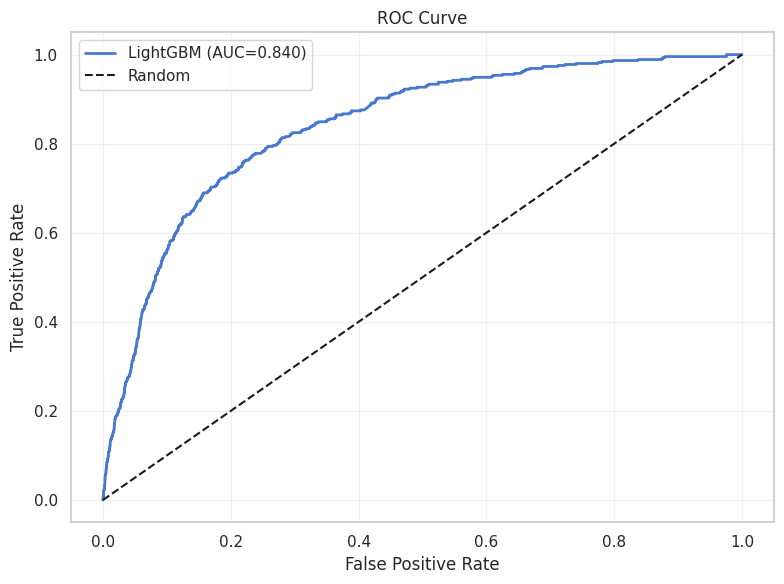

✅ Done


In [53]:
print("=== LightGBM Training ===")

# Preprocess
X_train_filled = X_train.fillna(X_train.median())
X_val_filled = X_val.fillna(X_train.median())

# Train
start_time = time.time()
model_lgb = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    random_state=42,
    verbose=-1,
    n_jobs=-1
)
model_lgb.fit(X_train_filled, y_train)
print(f"Training time: {time.time() - start_time:.2f}s")

# Predict & evaluate
y_pred = model_lgb.predict_proba(X_val_filled)[:, 1]
auc_score = roc_auc_score(y_val, y_pred)
print(f"AUC: {auc_score:.4f}")

# Plot AUC curve
fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', lw=2, label=f'LightGBM (AUC={roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: Save results
if 'labels' in locals():
    labels.append("LightGBM")
if 'y_preds' in locals():
    y_preds.append(y_pred)

print("✅ Done")

In [54]:
# Feature names sorted by importance
best_model = model_lgb
feat_imp = best_model.feature_importances_
feat_indices = np.argsort(feat_imp)[::-1]
important_feat = X_train.columns[feat_indices]
important_feat

Index(['var38', 'saldo_var30', 'saldo_medio_var5_hace3',
       'saldo_medio_var5_hace2', 'saldo_medio_var5_ult1', 'num_var22_ult3',
       'var38_log', 'saldo_var5', 'saldo_medio_var5_ult3',
       'avg_var15_saldo_medio_var8_hace2',
       ...
       'num_var12_0', 'num_var25',
       'avg_num_op_var41_comer_ult1_saldo_medio_var8_ult3', 'ind_var13',
       'num_aport_var13_hace3', 'num_var8', 'ind_var10_ult1', 'num_var14_0',
       'avg_num_op_var39_comer_ult1_saldo_medio_var8_ult3', 'ind_var30_0'],
      dtype='object', length=281)

In [55]:
# Save feature importance results
important_feat_df = pd.DataFrame({'feat_name': important_feat, 'feat_imp': feat_imp[feat_indices]})
important_feat_df.to_csv('/kaggle/working/' + dataset + '_feat_imp.csv', index=False, encoding='utf-8')

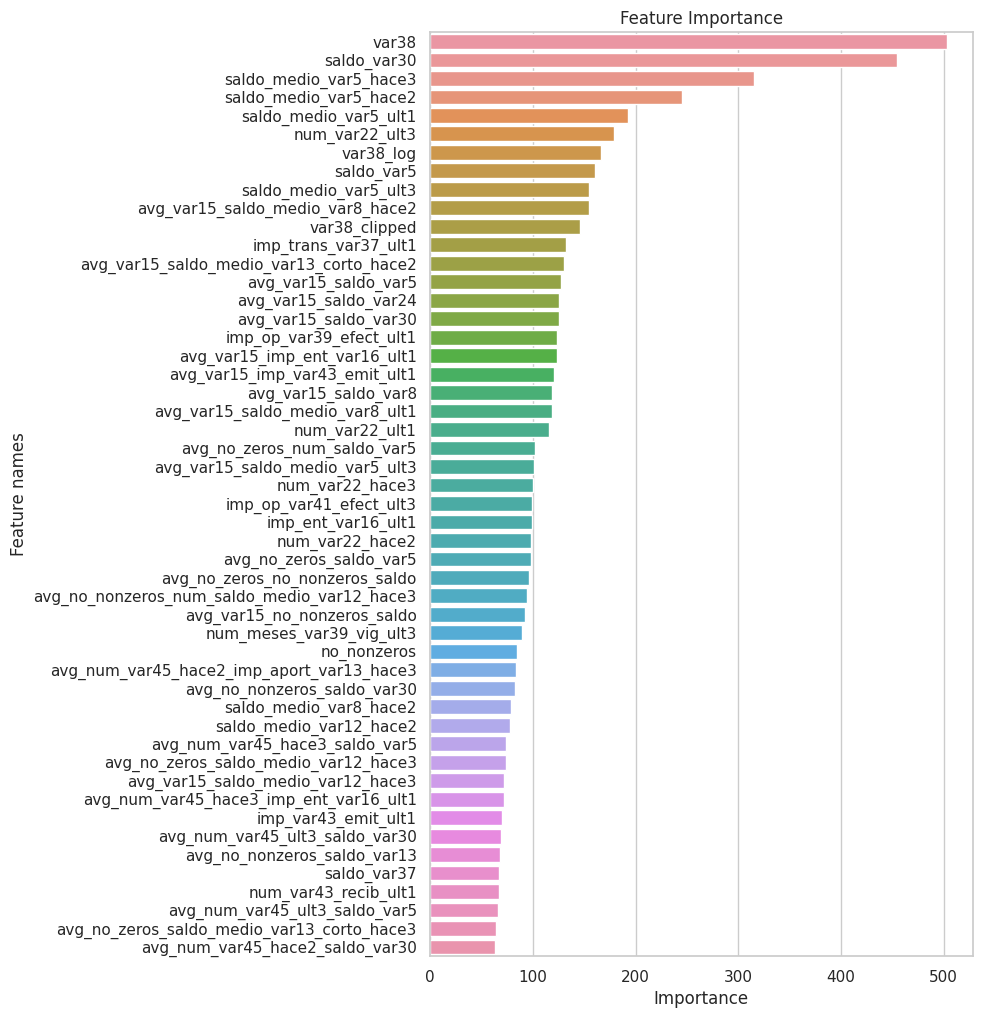

In [56]:
# Draw a ranking map of the top 50 features with the highest importance scores.
top = 50
top_indices = feat_indices[:top]
most_important_feat = X_train.columns[top_indices]
plt.figure(figsize=(7, 12))
sns.barplot(x=feat_imp[top_indices], y=most_important_feat)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel("Feature names")
plt.show()